In [2]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("objective", choices=["pred_noise", "pred_x0", "pred_v"], help="Objective to optimize")
parser.add_argument("--self_cond", action="store_true", help="Enable self-conditioning")
parser.add_argument("--lr", type=float, default=0.001, help="Learning rate for training")

args = parser.parse_args(["pred_noise", "--lr", "1e-4"] )
args

Namespace(objective='pred_noise', self_cond=False, lr=0.0001)

In [3]:
import os 
import transcript_data
import time
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import numpy as np
import glob
import importlib
import tcn
from pathlib import Path
import spliceAI
import matplotlib.pyplot as plt

#checkpoint_path = Path(f"checkpoints_diffusion_scan/{args.objective}_{args.self_cond}_{args.lr}")
checkpoint_path = Path(f"checkpoints_diffusion_binary/{args.objective}_{args.self_cond}_{args.lr}")

n_epoch = len(list(checkpoint_path.glob("*.pt")))

def get_acc(fn): 
    a=torch.load(fn, map_location=torch.device('cpu'))
    return(a['train_loss'], a['test_loss'])

train_loss, test_loss = zip(*[ get_acc(checkpoint_path / ("%i.pt" % i)) for i in range(n_epoch) ])


/gpfs/commons/home/daknowles/venv/mamba_ssm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


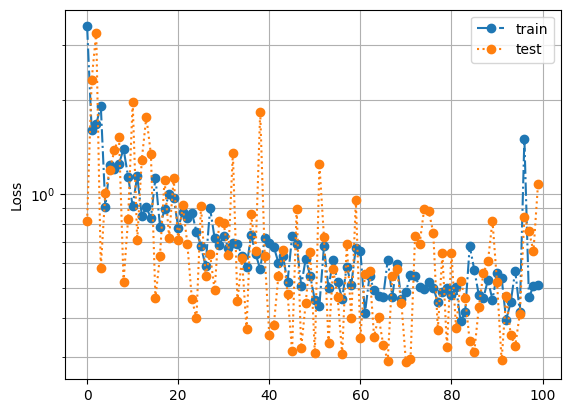

In [4]:
plt.plot(train_loss,"-.o",label="train")
plt.plot(test_loss,":o",label="test")
plt.legend()
plt.yscale("log")
plt.ylabel("Loss")
plt.grid()
plt.grid(which="minor")
plt.show()

In [19]:
import importlib
import denoising_diffusion_1d
from denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, extract

importlib.reload(denoising_diffusion_1d)

<module 'denoising_diffusion_1d' from '/gpfs/commons/home/daknowles/splice_wave/denoising_diffusion_1d.py'>

In [6]:

import denoising_diffusion_1d
from denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, extract

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seq_length = 16384 # 8192
get_gene = transcript_data.get_generator(
    os.path.expanduser("~/knowles_lab/index/hg38/hg38.fa.gz"), 
    "gencode.v24.annotation.gtf.gz",
    "ENCFF191YXW.tsv.gz") # neural cell polyA RNA-seq


train_chroms = ["chr%i" % i for i in range(2,23)] + ["chrX"]
test_chroms = ["chr1"]

# batch_size = 10. Cadaceus done 2^20 ~ 1M tokens per batch. So og is 10x smaller
train_dataloader = transcript_data.get_dataloader(get_gene, train_chroms, receptive_field = 0, batch_size = 20, device = device, max_len = seq_length )

# could use bigger batch here but want to be consistent with mamba
test_dataloader = transcript_data.get_dataloader(get_gene, test_chroms, receptive_field = 0, batch_size = 20, device = device, max_len = seq_length )


In [20]:

unet = Unet1D(
    dim = 32,
    dim_mults = (1, 2, 4, 4, 4, 4, 8),
    channels = 3,
    self_condition = args.self_cond
)

model = GaussianDiffusion1D(
    unet,
    seq_length = seq_length, 
    objective = args.objective
).to(device)

In [21]:
import glob
n_epoch = len(list(checkpoint_path.glob("*.pt")))
checkpoint = torch.load(checkpoint_path / ("%i.pt" % (n_epoch-1)), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
_ = model.to(device)

In [12]:
torch.set_grad_enabled(False)
model.eval()

for ((is_exon, lengths_), (one_hot, lengths), weights) in test_dataloader: 

    # convert to B x C x T (CNN) from B x T x C (RNN/transformer)
    # these are generated by rnn.pad_sequence internally
    one_hot = one_hot.permute(0, 2, 1).bool()
    is_exon = is_exon.permute(0, 2, 1)

    mask = is_exon.isnan() # record what is truly missing in is_exon (because of short genes)

    B,C,T = is_exon.shape # batch, channels, length

    binary_seq = torch.zeros(B, 2, T, device = device) 
    binary_seq[:, 0] = one_hot[:, 1, :] | one_hot[:, 3, :]
    binary_seq[:, 1] = one_hot[:, 2, :] | one_hot[:, 3, :]

    input = torch.concat( (is_exon, binary_seq), 1)
    if T < seq_length: # more succinct padding? 
        input = torch.concat( (input, torch.zeros(B,5,seq_length-T, device = device)), 2)
    break

In [14]:
x_missing = input.clone()
x_missing[:,0,:] = torch.nan # try to imput gene structure

In [22]:
U = 1
x_imputed = model.p_conditional_sample_loop(x_missing.to(device), U = U, clip_denoised = False)

sampling loop time step: 100%|██████████████████████████████████████████████| 1000/1000 [01:23<00:00, 11.94it/s]


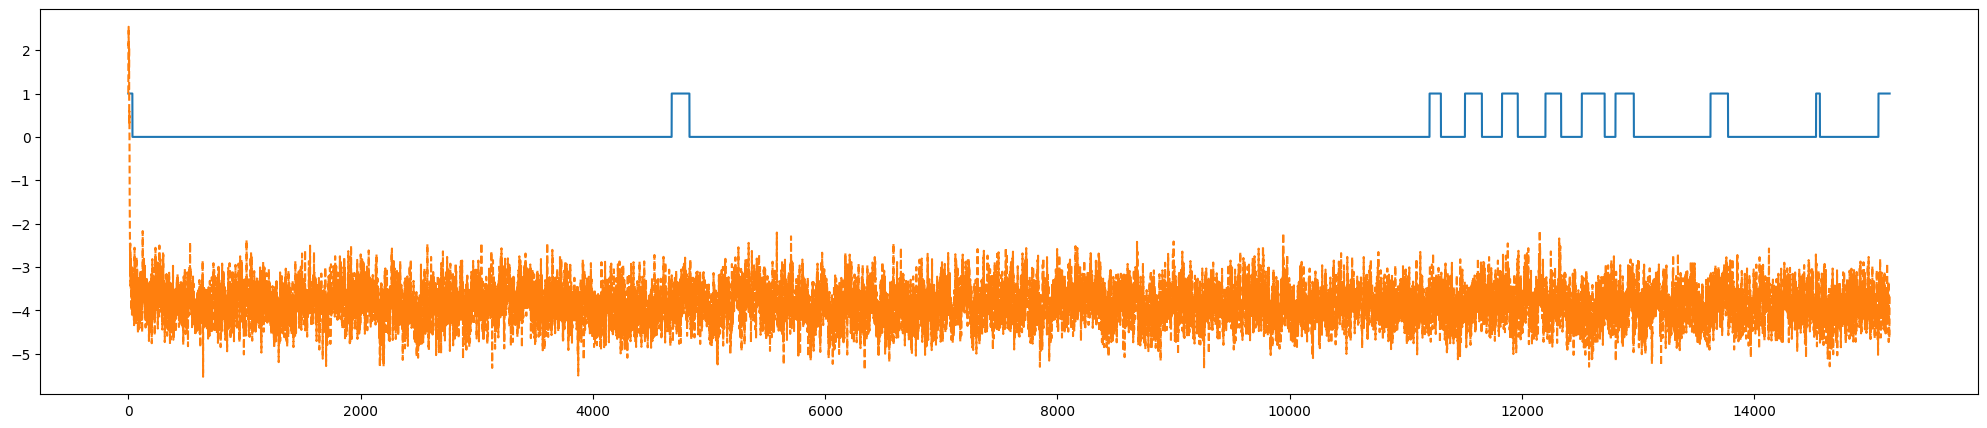

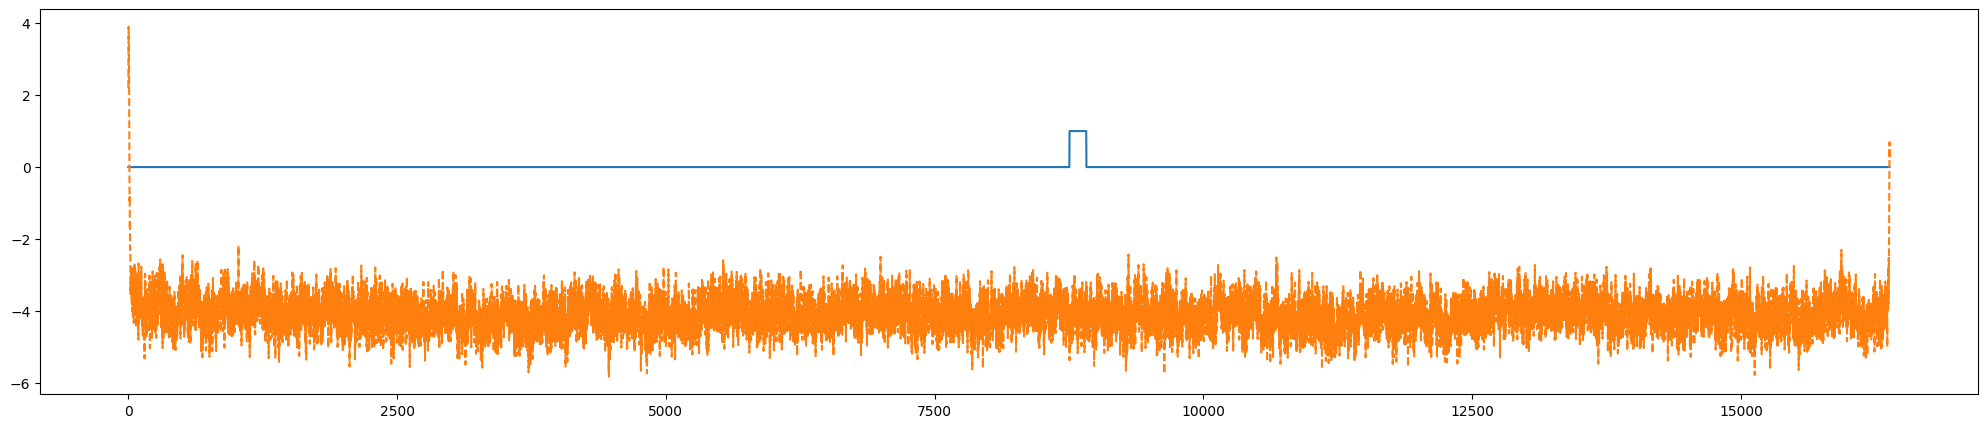

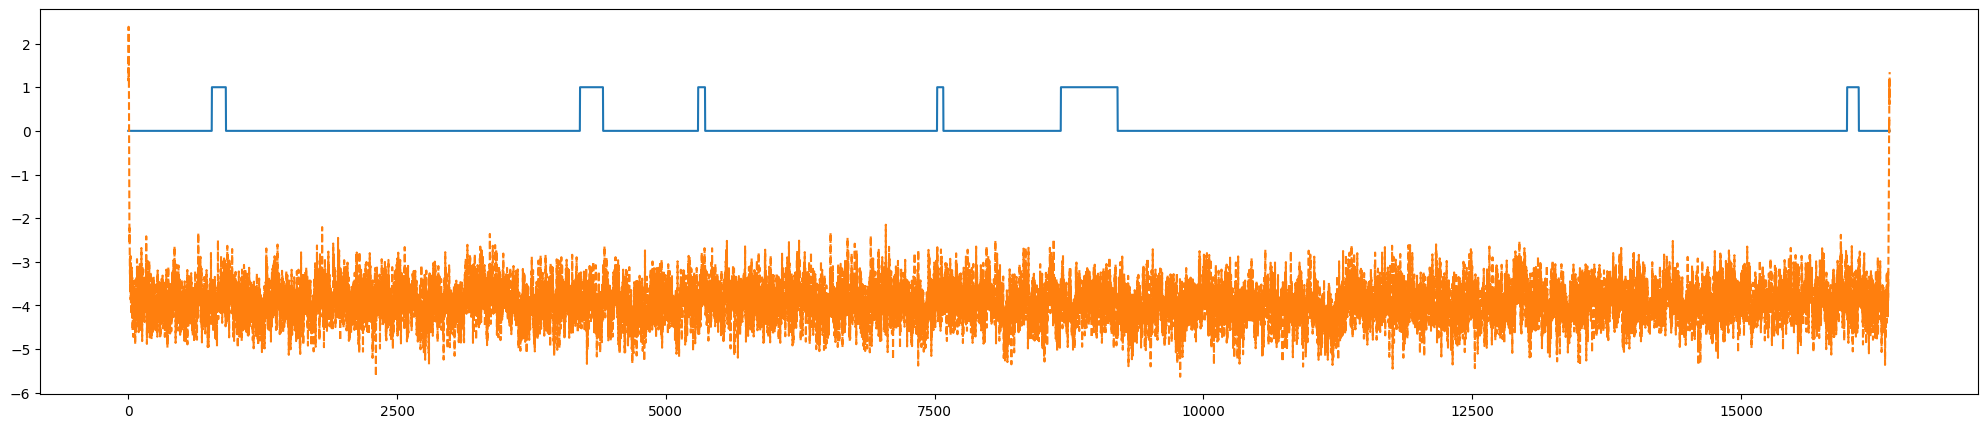

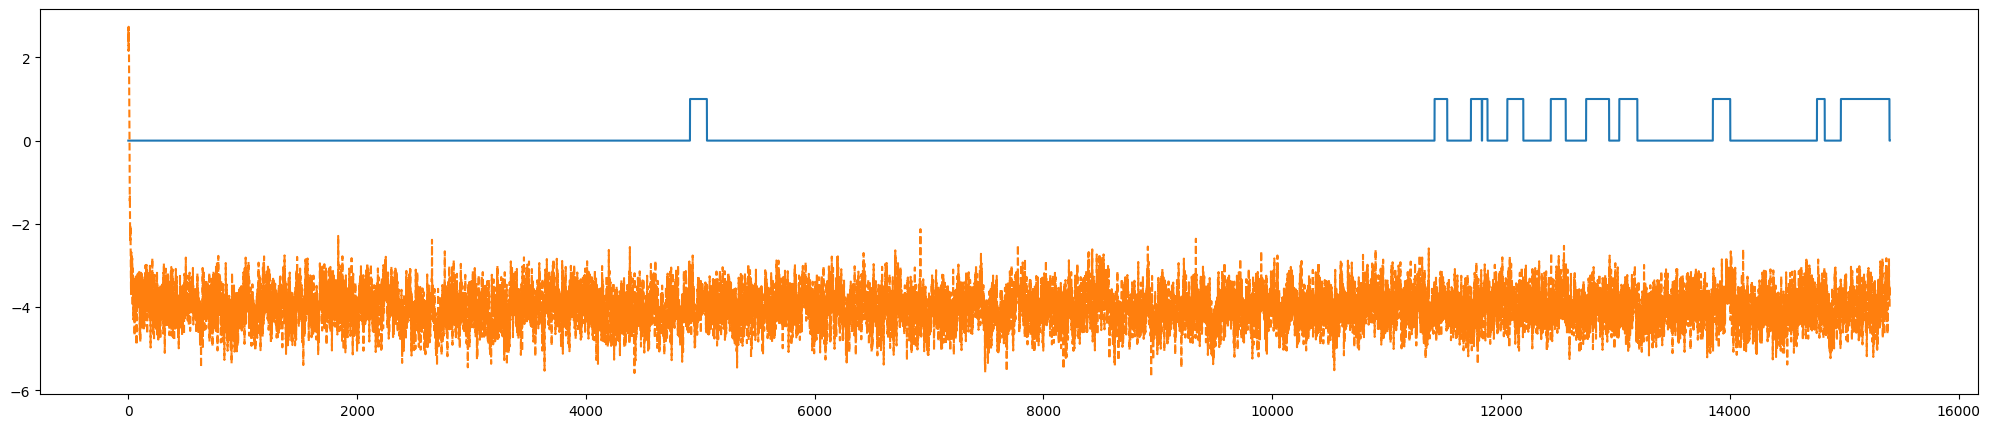

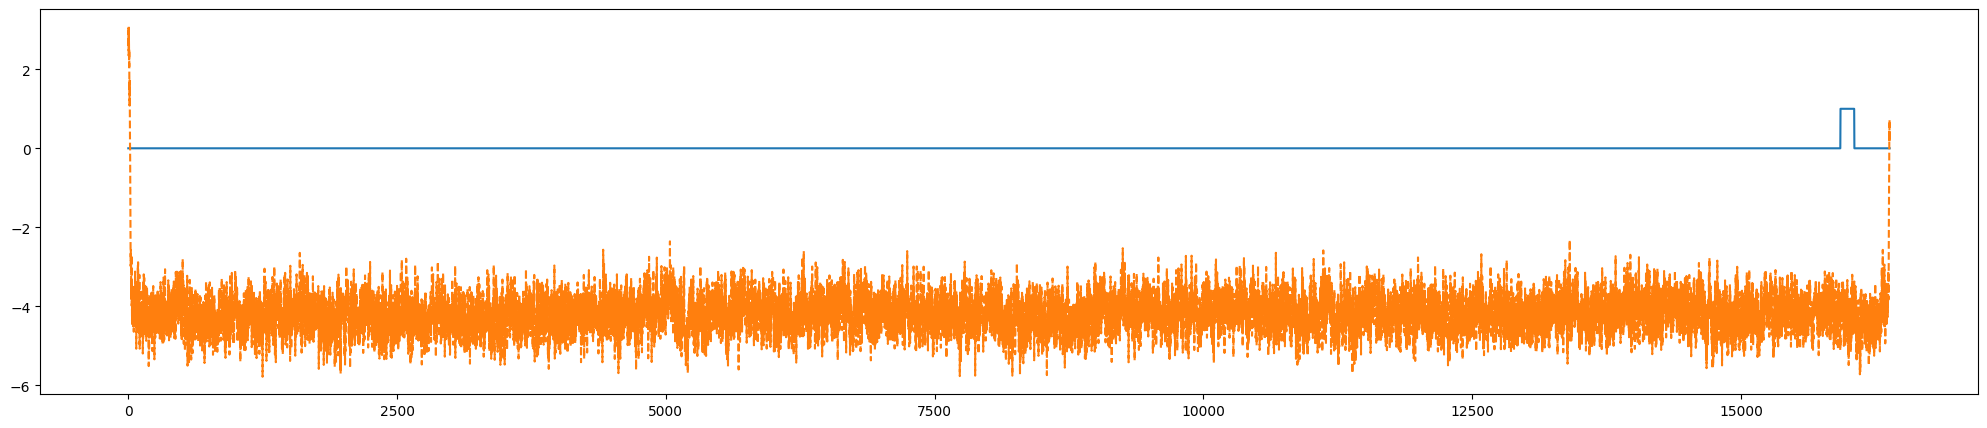

In [23]:
#plt.plot(input[0,0,:].cpu().numpy())
for i in range(5): 
    plt.figure(figsize = (25,5))
    plt.plot(input[i,0,:][ ~mask[i,0,:] ].detach().cpu().numpy())
    plt.plot( x_imputed[i,0,:][ ~mask[i,0,:] ].cpu().numpy(), "--" )
    plt.show()

In [ ]:
(x_imputed[:,0,:] - input[:,0,:].cpu()).abs().nanmean().item()

In [ ]:
input[:,0,:].cpu().abs().nanmean().item()

In [ ]:
(input[:,4,:].cpu()[~mask.cpu()[:,0,:] ] > 0.5).eq( x_imputed[:,4,:][~mask.cpu()[:,0,:] ] > 0.5 ).float().mean().item()
#(input[:,4,:].cpu() <= 0.5).float().mean().item()

In [ ]:
input[0,4,:]

In [ ]:
input.shape

In [21]:
x_sample = model.sample(8)

sampling loop time step: 100%|██████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.22it/s]


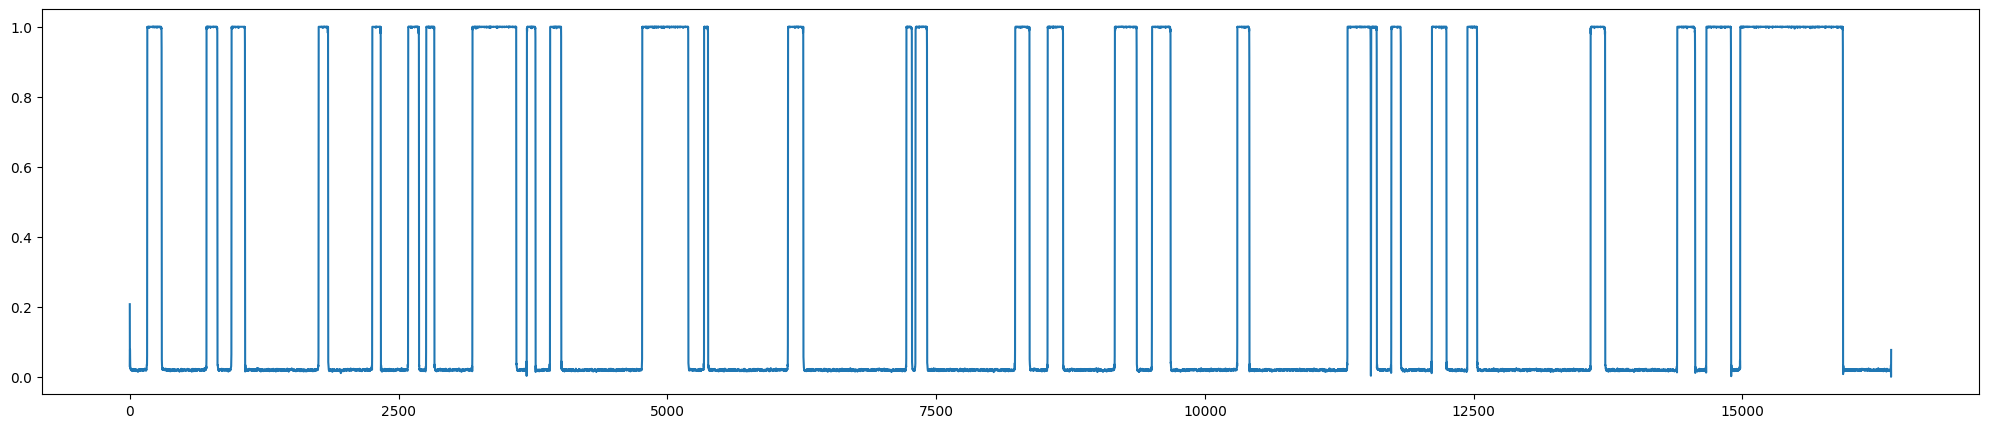

In [36]:
x_sample_np = x_sample.detach().cpu().numpy()
i= 0 
plt.figure(figsize = (25,5))
plt.plot(x_sample_np[i,0,:])
#plt.plot( x_imputed[i,0,:][ ~mask[i,0,:] ].cpu().numpy(), "--" )
plt.show()

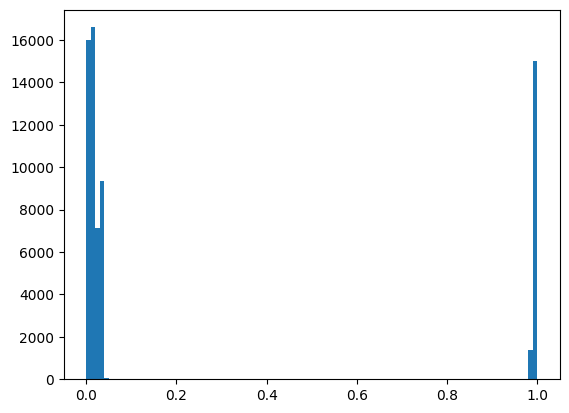

In [31]:
plt.hist(x_sample_np[i,1:,:].flatten(), 100)
plt.show()

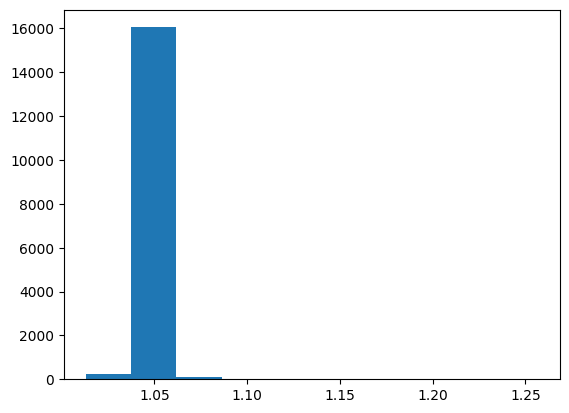

In [35]:
plt.hist(x_sample_np[i,1:,:].sum(0))
plt.show() # so does learn only one can be on